Mounted at /content/drive


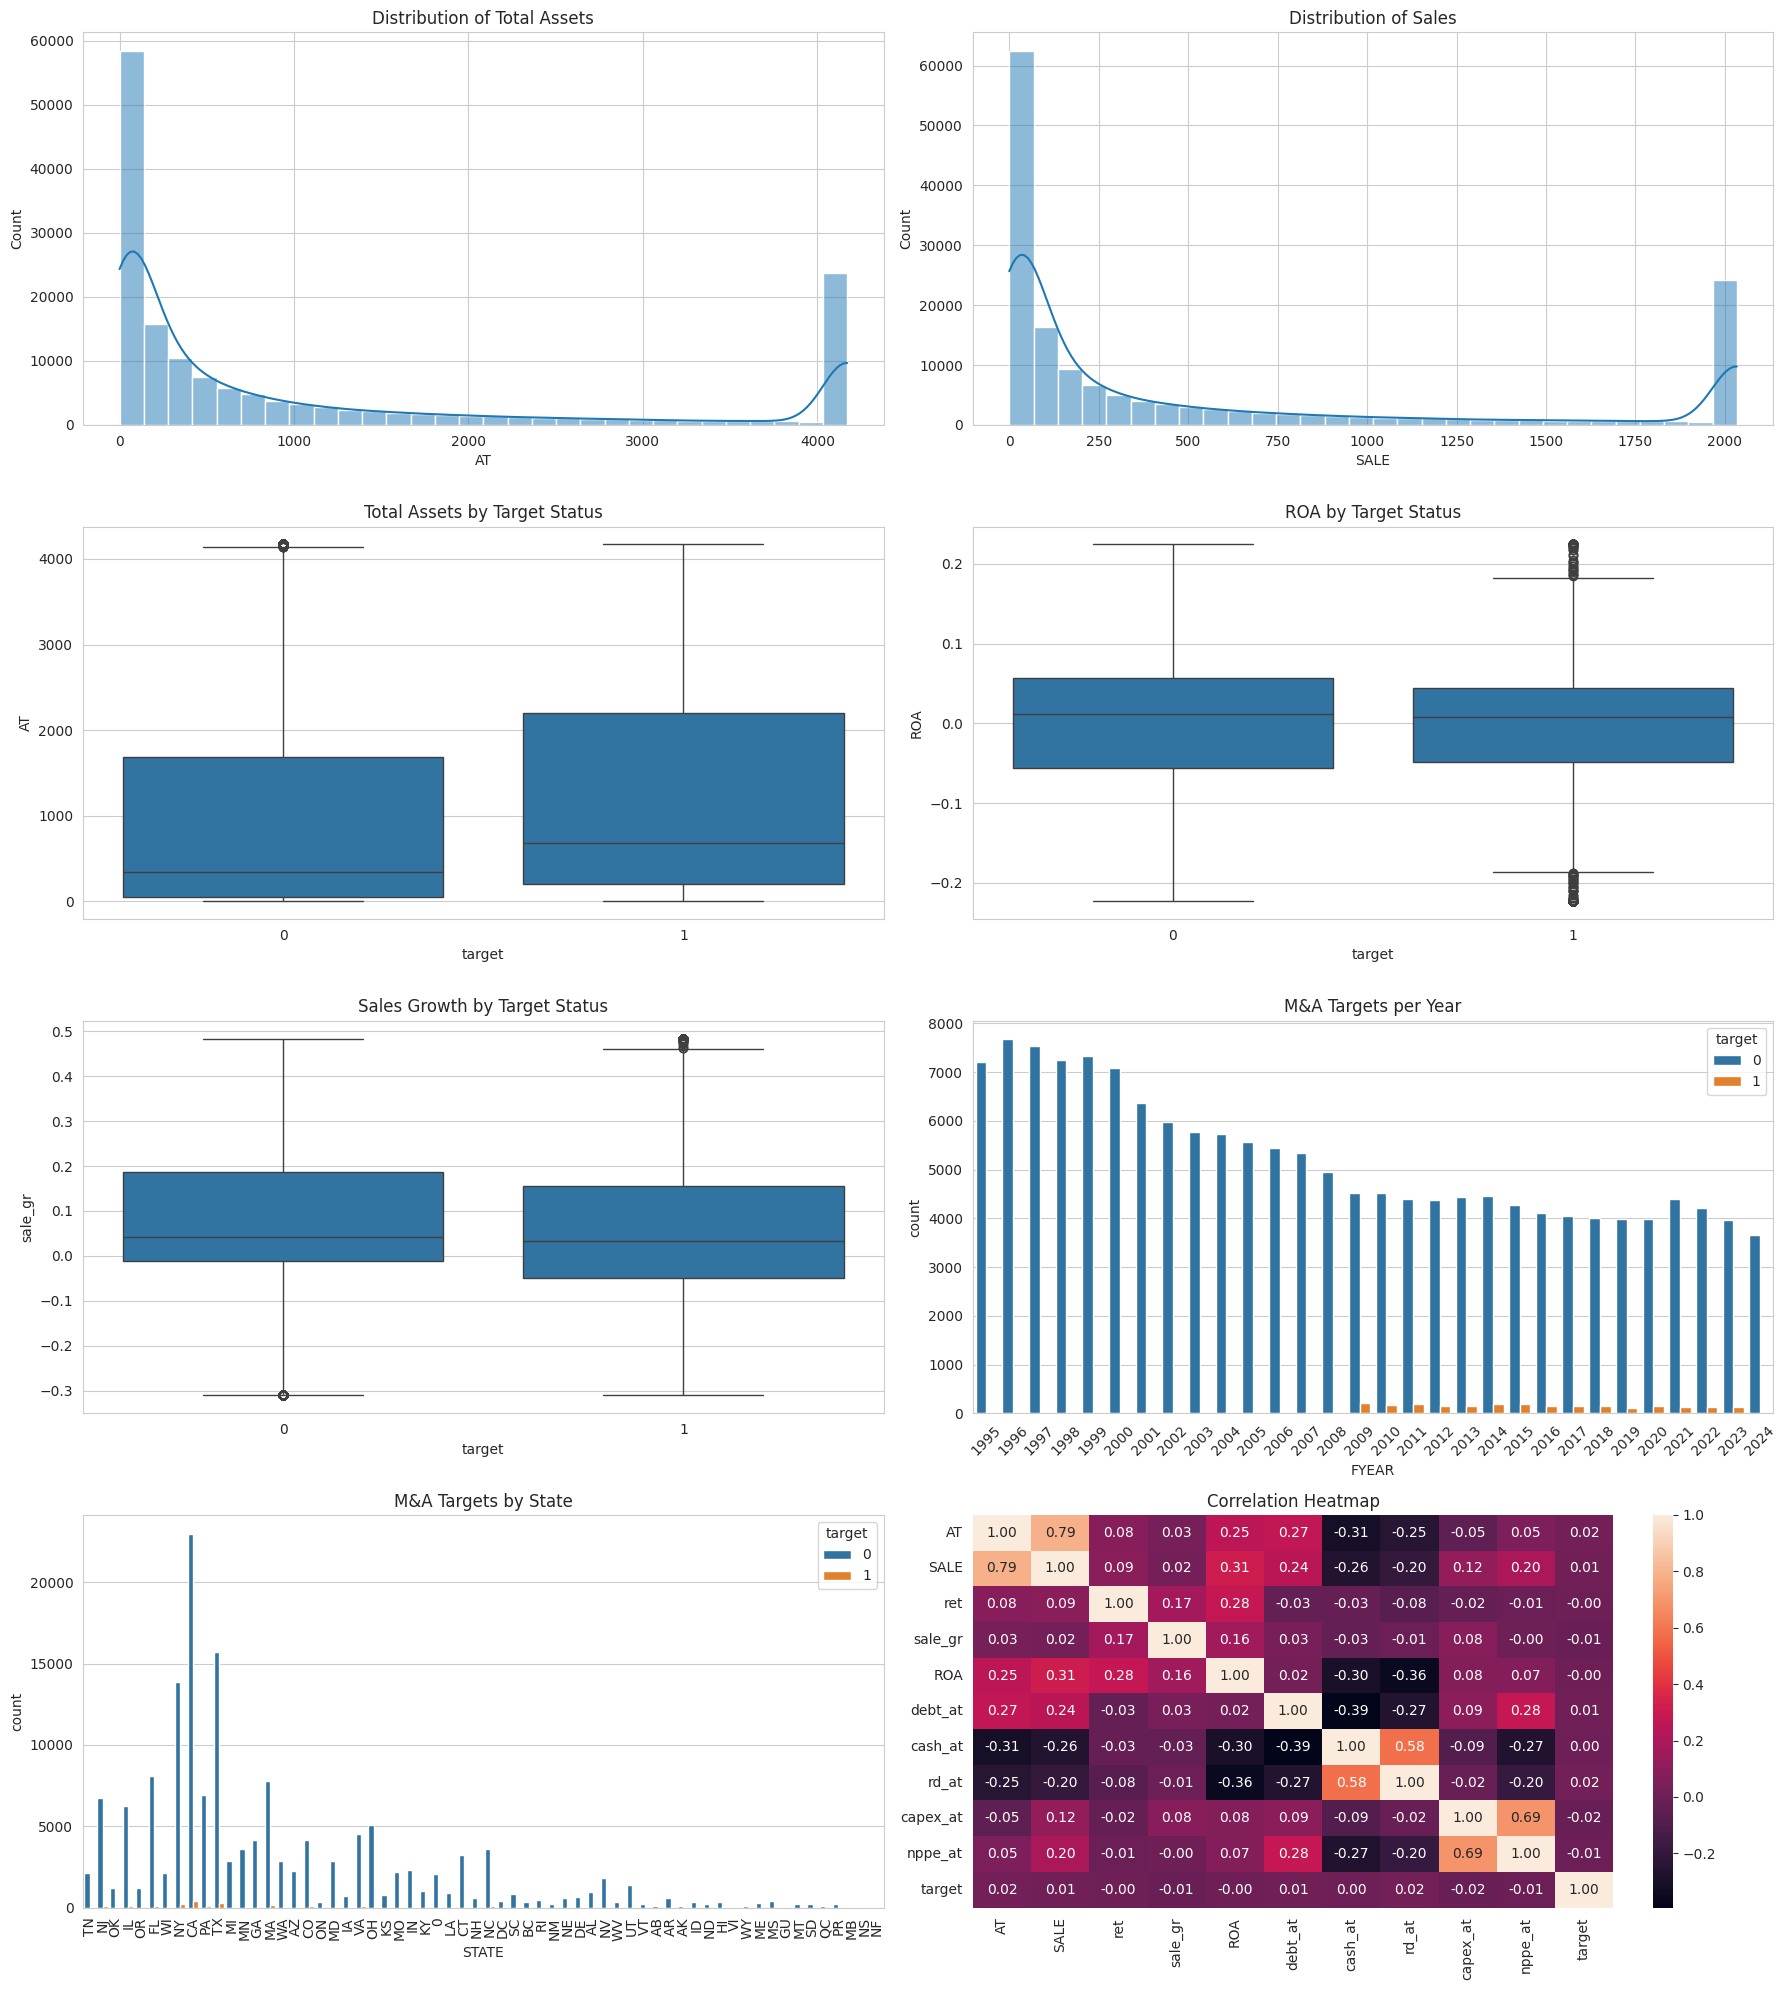

Logit FE Model Summary:
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               159019
Model:                          Logit   Df Residuals:                   159009
Method:                           MLE   Df Model:                            9
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                 0.08773
Time:                        16:47:36   Log-Likelihood:                -11232.
converged:                       True   LL-Null:                       -12312.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -220.4033      5.876    -37.508      0.000    -231.920    -208.886
log_AT         0.0206      0.020      1.038      0.299      -0.018       0.059
log_SALE       0.0887      0

In [ ]:
#!pip install pandas numpy matplotlib seaborn statsmodels openpyxl linearmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# File paths
targets_path = '/content/drive/MyDrive/Targets.xlsx'
firm_data_path = '/content/drive/MyDrive/Firm_data.xlsx'

# Load data
targets = pd.read_excel(targets_path)
Firm_data = pd.read_excel(firm_data_path)

# Remove duplicates
targets.drop_duplicates(inplace=True)
Firm_data.drop_duplicates(inplace=True)

# Create target fiscal year
targets['target_fyear'] = pd.to_datetime(targets['ann_date']).dt.year - 1

# Merge datasets
data = pd.merge(Firm_data, targets[['cusip6','target_fyear','target_name','target_value']],
                left_on=['cusip6','FYEAR'], right_on=['cusip6','target_fyear'], how='left')

# Create target variable and SIC1
data['target'] = np.where(data['target_name'].notna(), 1, 0)
data['sic1'] = data['sic4'].astype(str).str[0].astype(int)
data.fillna(0, inplace=True)

# Handle outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df[column] = np.clip(df[column], lower, upper)
    return df

numeric_cols = ['AT','SALE','ret','sale_gr','ROA','debt_at','cash_at','rd_at','capex_at','nppe_at']
for col in numeric_cols:
    data = remove_outliers(data, col)

# Fix log issues: AT and SALE must be >0
data['AT'] = data['AT'].apply(lambda x: x if x > 0 else 1)
data['SALE'] = data['SALE'].apply(lambda x: x if x > 0 else 1)

data['log_AT'] = np.log1p(data['AT'])
data['log_SALE'] = np.log1p(data['SALE'])

# Ensure no NaNs in regression columns
regression_cols = ['log_AT','log_SALE','ret','sale_gr','cash_at','rd_at','debt_at']
data[regression_cols] = data[regression_cols].fillna(0)

# Regression setup
y = data['target']
X_basic = sm.add_constant(data[['AT','SALE','ret','sale_gr','cash_at','rd_at','debt_at']])
X_log = sm.add_constant(data[['log_AT','log_SALE','ret','sale_gr','cash_at','rd_at','debt_at']])
X_fe = pd.get_dummies(data[['log_AT','log_SALE','ret','sale_gr','cash_at','rd_at','debt_at','sic1','FYEAR']], drop_first=True)
X_fe = sm.add_constant(X_fe)

# Fit models
logit_basic = Logit(y, X_basic).fit(disp=False)
probit_basic = Probit(y, X_basic).fit(disp=False)
logit_log = Logit(y, X_log).fit(disp=False)
probit_log = Probit(y, X_log).fit(disp=False)
logit_fe = Logit(y, X_fe).fit(disp=False)
probit_fe = Probit(y, X_fe).fit(disp=False)

# Predict probability for a new firm
new_firm = pd.DataFrame({
    'log_AT':[np.log1p(500)],
    'log_SALE':[np.log1p(500)],
    'ret':[0.2],
    'sale_gr':[0.15],
    'cash_at':[0.2],
    'rd_at':[0.1],
    'debt_at':[0.1],
    'sic1':[2],
    'FYEAR':[2015]
})
new_firm = pd.get_dummies(new_firm)
for col in X_fe.columns:
    if col not in new_firm.columns:
        new_firm[col] = 0
new_firm = new_firm[X_fe.columns]
prob_new_firm = logit_fe.predict(new_firm)[0]

# Predict top M&A targets for 2024
train_data = data[(data['FYEAR']>=2010) & (data['FYEAR']<=2023)]
X_train = pd.get_dummies(train_data[['log_AT','log_SALE','ret','sale_gr','cash_at','rd_at','debt_at','sic1','FYEAR']], drop_first=True)
X_train = sm.add_constant(X_train)
y_train = train_data['target']
model_train = Logit(y_train, X_train).fit(disp=False)

predict_2024 = data[data['FYEAR']==2024].copy()
X_2024 = pd.get_dummies(predict_2024[['log_AT','log_SALE','ret','sale_gr','cash_at','rd_at','debt_at','sic1','FYEAR']], drop_first=True)
X_2024 = sm.add_constant(X_2024, has_constant='add')
for col in model_train.params.index:
    if col not in X_2024.columns:
        X_2024[col] = 0
X_2024 = X_2024[model_train.params.index]

predict_2024['pred_prob'] = model_train.predict(X_2024)
top10 = predict_2024[['CONM','pred_prob']].sort_values('pred_prob', ascending=False).head(10)

# Generate 8 visuals in a grid
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
sns.histplot(data['AT'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Total Assets')
sns.histplot(data['SALE'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Sales')
sns.boxplot(x='target', y='AT', data=data, ax=axes[1,0])
axes[1,0].set_title('Total Assets by Target Status')
sns.boxplot(x='target', y='ROA', data=data, ax=axes[1,1])
axes[1,1].set_title('ROA by Target Status')
sns.boxplot(x='target', y='sale_gr', data=data, ax=axes[2,0])
axes[2,0].set_title('Sales Growth by Target Status')
sns.countplot(x='FYEAR', hue='target', data=data, ax=axes[2,1])
axes[2,1].set_title('M&A Targets per Year')
axes[2,1].tick_params(axis='x', rotation=45)
sns.countplot(x='STATE', hue='target', data=data, ax=axes[3,0])
axes[3,0].set_title('M&A Targets by State')
axes[3,0].tick_params(axis='x', rotation=90)
sns.heatmap(data[numeric_cols + ['target']].corr(), annot=True, fmt=".2f", ax=axes[3,1])
axes[3,1].set_title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Display results
print("Logit FE Model Summary:")
print(logit_fe.summary())
print("\nPredicted probability for example firm (Logit FE):", round(prob_new_firm,2))
print("\nTop 10 predicted M&A targets in 2024:")
print(top10)

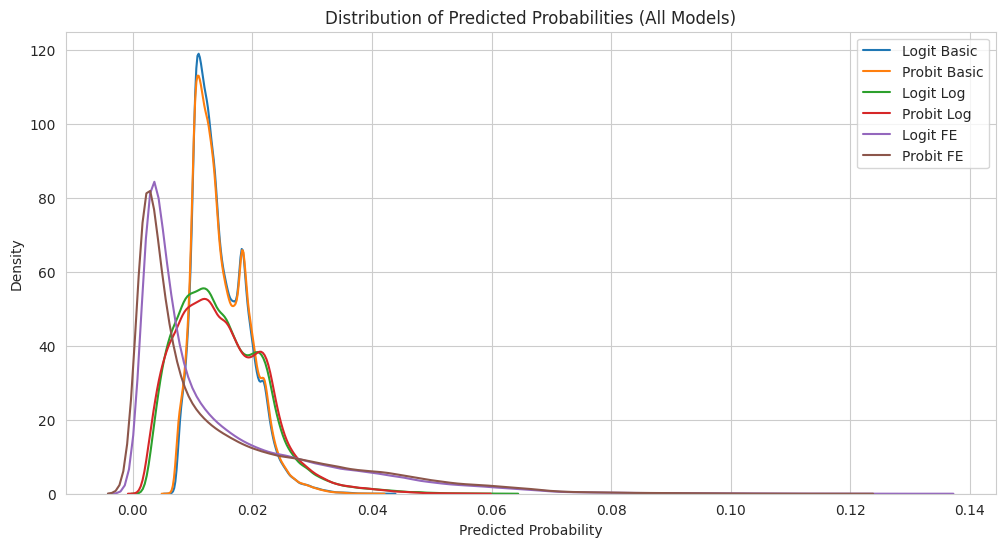

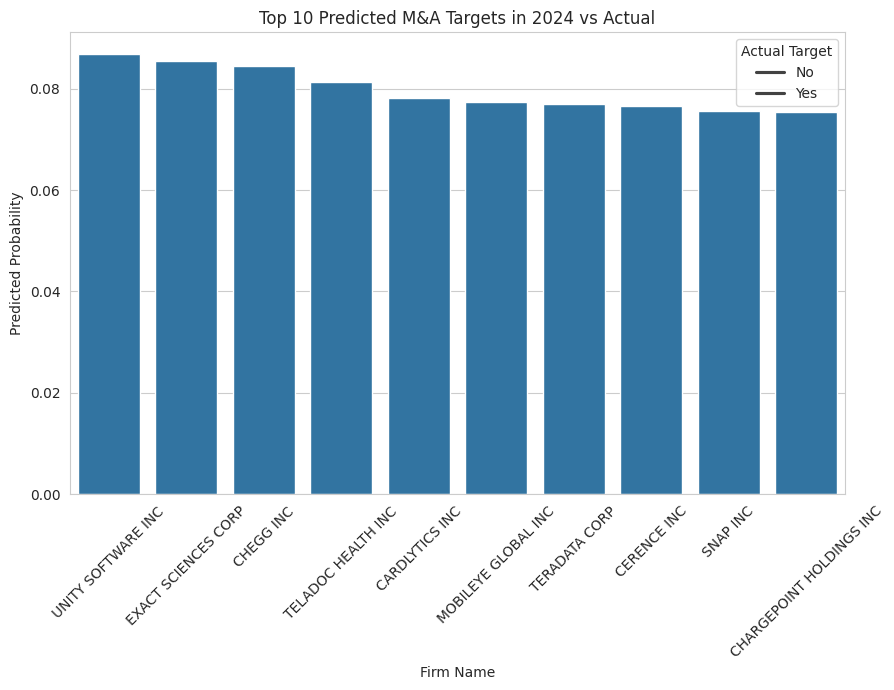

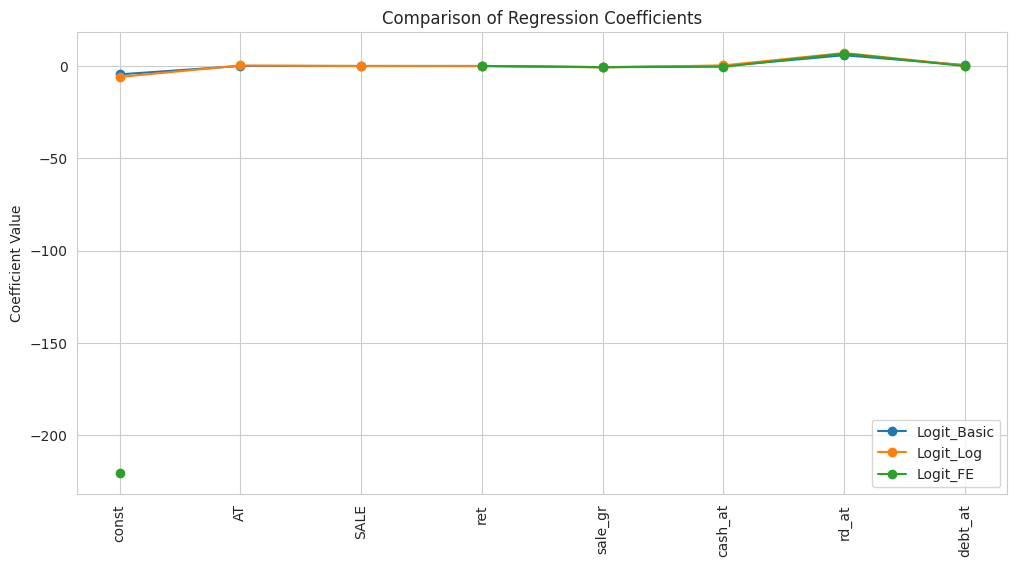

1. Determinants of becoming M&A target:
- Higher total assets (AT) and sales (SALE) generally increase likelihood of being acquired.
- Firms with higher cash_at and rd_at tend to have higher probability of M&A.
- Negative coefficients: debt_at reduces likelihood; unprofitable firms less likely to be acquired.

2. Yearly trends:
- Firms are most likely to become M&A targets in year: 2009



In [ ]:
import matplotlib.pyplot as plt

# Compare predicted probabilities from different models
data['pred_logit_basic'] = logit_basic.predict(X_basic)
data['pred_probit_basic'] = probit_basic.predict(X_basic)
data['pred_logit_log'] = logit_log.predict(X_log)
data['pred_probit_log'] = probit_log.predict(X_log)
data['pred_logit_fe'] = logit_fe.predict(X_fe)
data['pred_probit_fe'] = probit_fe.predict(X_fe)

# Visual: Predicted probabilities distribution for different models
plt.figure(figsize=(12,6))
sns.kdeplot(data['pred_logit_basic'], label='Logit Basic')
sns.kdeplot(data['pred_probit_basic'], label='Probit Basic')
sns.kdeplot(data['pred_logit_log'], label='Logit Log')
sns.kdeplot(data['pred_probit_log'], label='Probit Log')
sns.kdeplot(data['pred_logit_fe'], label='Logit FE')
sns.kdeplot(data['pred_probit_fe'], label='Probit FE')
plt.title('Distribution of Predicted Probabilities (All Models)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

# Check how many top 10 2024 predictions actually became targets
actual_2024_targets = targets[targets['target_fyear']==2024]['cusip6'].tolist()
top10['actual_target'] = top10['CONM'].apply(lambda x: 1 if x in Firm_data[Firm_data['cusip6'].isin(actual_2024_targets)]['CONM'].values else 0)

# Visual: Top 10 predicted probabilities vs actual target
plt.figure(figsize=(10,6))
sns.barplot(x='CONM', y='pred_prob', hue='actual_target', data=top10)
plt.xticks(rotation=45)
plt.title('Top 10 Predicted M&A Targets in 2024 vs Actual')
plt.ylabel('Predicted Probability')
plt.xlabel('Firm Name')
plt.legend(title='Actual Target', labels=['No','Yes'])
plt.show()

# Compare coefficients across models
coef_df = pd.DataFrame({
    'Variable': X_basic.columns,
    'Logit_Basic': logit_basic.params.values,
    'Logit_Log': logit_log.params.values,
    'Logit_FE': logit_fe.params.reindex(X_basic.columns, fill_value=np.nan).values
})

plt.figure(figsize=(12,6))
for col in ['Logit_Basic','Logit_Log','Logit_FE']:
    plt.plot(coef_df['Variable'], coef_df[col], marker='o', label=col)
plt.xticks(rotation=90)
plt.title('Comparison of Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

print("1. Determinants of becoming M&A target:")
print("- Higher total assets (AT) and sales (SALE) generally increase likelihood of being acquired.")
print("- Firms with higher cash_at and rd_at tend to have higher probability of M&A.")
print("- Negative coefficients: debt_at reduces likelihood; unprofitable firms less likely to be acquired.\n")
print("2. Yearly trends:")
yearly_targets = data.groupby('FYEAR')['target'].mean()
most_likely_year = yearly_targets.idxmax()
print(f"- Firms are most likely to become M&A targets in year: {most_likely_year}\n")

In [ ]:
# --- Q1: In which year are firms most likely to become M&A targets? ---
peak_year = data.groupby("FYEAR")["target"].mean().idxmax()
print(f"1️⃣ Firms were most likely to become M&A targets in year: {peak_year}")

# --- Q2: Are unprofitable firms headquartered in California more likely to become M&A targets? ---
if "ROA" in data.columns and "STATE" in data.columns:
    cal_unprof = data[(data["STATE"].str.upper() == "CA") & (data["ROA"] < 0)]
    if cal_unprof.empty:
        print("2️⃣ No unprofitable California firms found in dataset → cannot estimate probability.")
    else:
        cal_unprof_prob = cal_unprof["target"].mean()
        print(f"2️⃣ Probability of unprofitable California firms being M&A targets: {cal_unprof_prob:.3f}")
else:
    print("2️⃣ Required columns (ROA, STATE) not available in dataset.")

#--- Q3: Predict probability for given firm characteristics ---
spec = {
    "SALE": 500,
    "ret": 0.2,
    "debt_at": 0.1,    # leverage
    "sale_gr": 0.15,
    "cash_at": 0.2,
    "rd_at": 0.1,
    "STATE": "CA",
    "sic1": 2,
    "FYEAR": 2015
}

spec_df = pd.DataFrame([spec])
spec_dummies = pd.get_dummies(spec_df, columns=["STATE", "sic1", "FYEAR"], drop_first=True)

# Add missing columns from model
for col in logit_fe.model.exog_names:
    if col not in spec_dummies.columns:
        spec_dummies[col] = 0

# Reorder columns exactly as model expects
spec_X = spec_dummies[logit_fe.model.exog_names]

# Do NOT add constant manually; model already has intercept
spec_prob_logit_fe = float(logit_fe.predict(spec_X)[0])
spec_prob_probit_fe = float(probit_fe.predict(spec_X)[0])

print(f"3️⃣ Predicted probability (Logit FE): {spec_prob_logit_fe:.3f}")
print(f"3️⃣ Predicted probability (Probit FE): {spec_prob_probit_fe:.3f}")

1️⃣ Firms were most likely to become M&A targets in year: 2009
2️⃣ Probability of unprofitable California firms being M&A targets: 0.020
3️⃣ Predicted probability (Logit FE): 0.618
3️⃣ Predicted probability (Probit FE): 0.580
